In [1]:
import yaml
import glob
import os
import pathlib
import sklearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.model_selection import train_test_split

import joblib
from joblib import dump

## Path and Files

In [9]:
TRAINING_CSV_PATH = 'C:/Users/compte/Documents/hands-on-2021/data/raw/GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [10]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)

In [11]:
def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    
    A list of images as Numpy arrays 
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        image = image.flatten()
        images_list.append(image)
        
    return images_list

In [12]:
def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values

In [13]:
images_df = build_images_database(TRAINING_CSV_PATH)
#images_df = shuffle(images_df)
#images_df.head()

In [15]:
# Reading only 200 images for the moment
#N = 1000
images_list = build_images_list(images_df['path'].values)


data = np.array(images_list)
labels = build_classes_array(images_df)

print(data.shape, labels.shape)

(39209, 2700) (39209,)


## Train the model

In [16]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2 ,random_state= 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


In [18]:
from sklearn import svm
sv = svm.LinearSVC(C=1.0, multi_class='ovr')
sv.fit(X_train, y_train)

C:\Users\compte\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

## Save the model

In [20]:
dump(sv, 'C:/Users/compte/Documents/hands-on-2021/models/svmmodel.pkl')

['C:/Users/compte/Documents/hands-on-2021/models/svmmodel.pkl']

## Validation

In [21]:
import sklearn

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [22]:
y_pred = sv.predict(X_test)

In [23]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = y_test
accuracy_df['predicted'] = y_pred

Le taux de précision du modèle SVM s'élève à : 90.95%


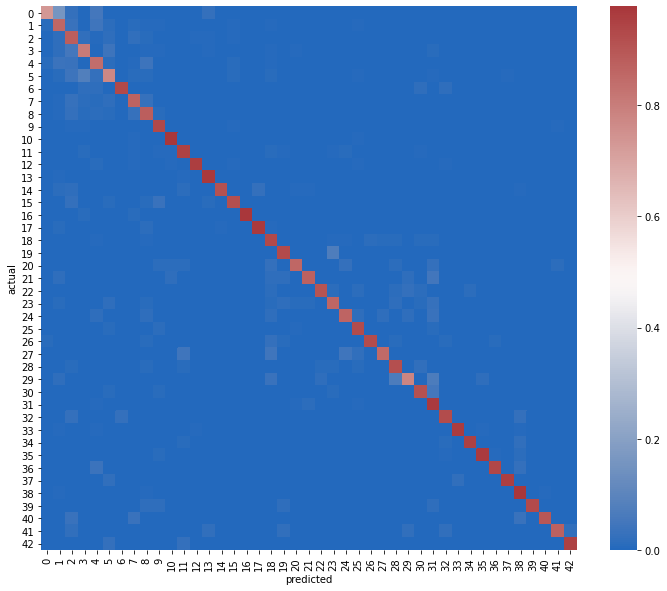

In [24]:
sk = sklearn.metrics.accuracy_score(y_test, y_pred)*100
print("Le taux de précision du modèle SVM s'élève à : {:.2f}%".format(sk))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

## Testing

In [25]:
test_images_df = pd.read_csv('C:/Users/compte/Documents/hands-on-2021/data/raw/GT-final_test.csv', sep=';')
test_images_df['path']=test_images_df['Filename'].apply(lambda x:'C:/Users/compte/Documents/hands-on-2021/data/raw/GTSRB/Final_Test/Images/'+x)
test_images_df.head()
#test_images_df.tail() # Voir fin du fichier

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000.ppm,53,54,6,5,48,49,16,C:/Users/compte/Documents/hands-on-2021/data/r...
1,00001.ppm,42,45,5,5,36,40,1,C:/Users/compte/Documents/hands-on-2021/data/r...
2,00002.ppm,48,52,6,6,43,47,38,C:/Users/compte/Documents/hands-on-2021/data/r...
3,00003.ppm,27,29,5,5,22,24,33,C:/Users/compte/Documents/hands-on-2021/data/r...
4,00004.ppm,60,57,5,5,55,52,11,C:/Users/compte/Documents/hands-on-2021/data/r...


In [26]:
# Recharger les images qui permettent d'affichier les formes 
test_list = build_images_list(test_images_df['path'].values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

In [27]:
%%time
results = sv.predict(test_data)

Wall time: 165 ms


In [28]:
(test_labels == results).sum()/ test_labels.shape[0]

0.813064133016627

In [29]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

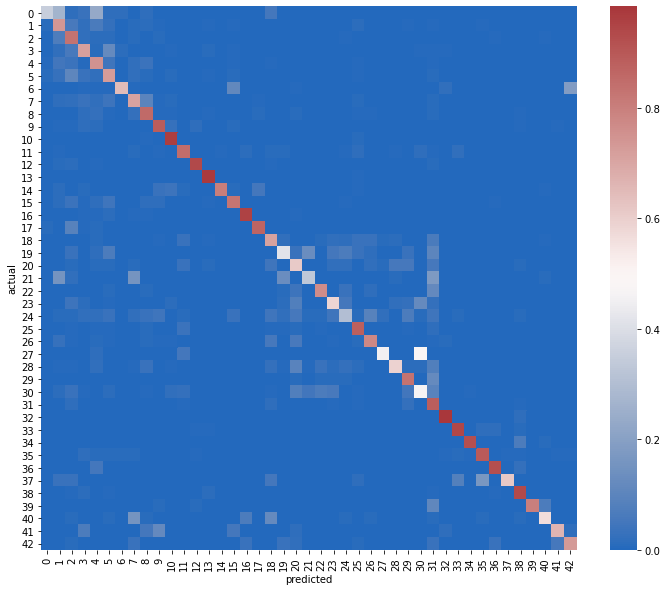

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);